# Evaluation using QCB chemicals (medium)

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import os
from os.path import exists
import copy

import pylab as plt
from loguru import logger
import seaborn as sns
import gymnasium as gym
import pandas as pd
import torch

from vimms.Evaluation import EvaluationData
from vimms.Common import set_log_level_warning, load_obj, save_obj
from vimms.Noise import UniformSpikeNoise
from vimms.Roi import RoiBuilderParams, SmartRoiParams

from vimms_gym.common import METHOD_DQN, evaluate
from vimms_gym.chemicals import generate_chemicals
from vimms_gym.evaluation import run_method
from vimms_gym.common import METHOD_RANDOM, METHOD_TOPN
from vimms_gym.experiments import preset_qcb_medium

from model.QNetwork import get_QNetwork, QNETWORK_CNN
from model.DQN_utils import make_env, masked_epsilon_greedy

# 1. Parameters

Parameters that will be used throughout this notebook. Should be the same as the training ones.

Chemical generation parameters

In [4]:
env_alpha = 0.25
env_beta = 0.50
extract = True
params, max_peaks = preset_qcb_medium(None, alpha=env_alpha, beta=env_beta, extract_chromatograms=extract)
params, max_peaks

2023-06-11 02:05:49.975 | INFO     | vimms_gym.experiments:get_samplers:303 - Loaded /notebooks/vimms-gym/pickles/samplers_QCB_medium_extracted.p


({'chemical_creator': {'mz_range': (100, 600),
   'rt_range': (400, 800),
   'intensity_range': (10000.0, 1e+20),
   'n_chemicals': (200, 500),
   'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f3aea1f2ee0>,
   'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f3a3a955fa0>,
   'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f3a3aa2a610>},
  'noise': {'enable_spike_noise': True,
   'noise_density': 0.1,
   'noise_max_val': 1000.0,
   'mz_range': (100, 600)},
  'env': {'ionisation_mode': 'Positive',
   'rt_range': (400, 800),
   'isolation_window': 0.7,
   'use_dew': False,
   'mz_tol': 10,
   'rt_tol': 5,
   'min_ms1_intensity': 5000,
   'alpha': 0.25,
   'beta': 0.5}},
 30)

In [5]:
# n_chemicals = (200, 500)
# mz_range = (100, 600)
# rt_range = (400, 800)
# intensity_range = (1E4, 1E20)

Evaluation parameters

In [6]:
env_name = 'DDAEnv'
intensity_threshold = 0.5

dqn_in_dir = 'DQN_1.0E6'

# ppo_in_dir = os.path.join('..', '..', 'tune', 'QCB_resimulated_medium')
ppo_in_dir = 'PPO_1.0E6'

methods = [
    METHOD_RANDOM,
    METHOD_TOPN,
]
valid_random = True
n_eval_episodes = 30

In [7]:
# topN parameters
topN_N = 10
topN_rt_tol = 5
min_ms1_intensity = 5000

# smartroi parameters
alpha = 2
beta = 0.5
ils = 0
smartroi_N = topN_N
smartroi_dew = topN_rt_tol

# weighteddew parameters
t0 = 3
t1 = 15
weighteddew_N = 10

## Generate chemical sets for evaluation

In [8]:
fname = 'QCB_chems_medium.p'
found = exists(fname)
if found:
    chem_list = load_obj(fname)
    for chems in chem_list:
        print(len(chems))

426
262
394
452
437
200
478
204
424
384
443
249
251
300
206
407
498
372
302
265
468
234
322
310
345
396
203
281
493
304


Generate new chemicals if not found

In [9]:
params['chemical_creator']

{'mz_range': (100, 600),
 'rt_range': (400, 800),
 'intensity_range': (10000.0, 1e+20),
 'n_chemicals': (200, 500),
 'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f3aea1f2ee0>,
 'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f3a3a955fa0>,
 'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f3a3aa2a610>}

In [10]:
if not found:
    repeat = 30
    logger.warning('Generating chemicals')
    
    chemical_creator_params = params['chemical_creator']
    chem_list = []
    for i in range(repeat):
        chems = generate_chemicals(chemical_creator_params)
        print(len(chems))
        chem_list.append(chems)
        
    save_obj(chem_list, fname)

In [11]:
chem_list = chem_list[0:n_eval_episodes]
len(chem_list)

30

# 2. Evaluation

In [12]:
set_log_level_warning()

1

In [13]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f3aea1f2ee0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f3a3a955fa0>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f3a3aa2a610>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.25,
  'beta': 0.5}}

In [14]:
horizon = 1
out_dir = 'evaluation_1.0E6_horizon_%d_alpha_%.2f_beta_%.2f' % (horizon, env_alpha, env_beta)

In [15]:
method_eval_results = {}
for method in methods:

    N = 0
    copy_params = copy.deepcopy(params)            
    custom_objects = {
        "learning_rate": 0.0,
        "lr_schedule": lambda _: 0.0,
        "clip_range": lambda _: 0.0,
    }    
    
    model = None
    if method == METHOD_TOPN:
        N = topN_N
        effective_rt_tol = topN_rt_tol
        copy_params['env']['use_dew'] = True
        copy_params['env']['rt_tol'] = effective_rt_tol                        

    banner = 'method = %s max_peaks = %d N = %d rt_tol = %d' % (method, max_peaks, N, 
                                                                                   copy_params['env']['rt_tol'])
    print(banner)
    print()            
            
    episodic_results = run_method(env_name, copy_params, max_peaks, chem_list, method, out_dir, 
                                  N=N, min_ms1_intensity=min_ms1_intensity, model=model,
                                  print_eval=True, print_reward=True, intensity_threshold=intensity_threshold,
                                  mzml_prefix=method, horizon=horizon, valid_random=valid_random)
    eval_results = [er.eval_res for er in episodic_results]
    method_eval_results[method] = eval_results
    print()

method = random max_peaks = 30 N = 0 rt_tol = 5


Episode 0 (426 chemicals)
steps	 500 	total rewards	 99.68878445439663
steps	 1000 	total rewards	 119.19906412523368
steps	 1500 	total rewards	 128.53159518327124
Finished after 1792 timesteps (2.245718479156494 seconds) with total reward 98.79642180678975
{'coverage_prop': '0.923', 'intensity_prop': '0.685', 'ms1ms2_ratio': '0.131', 'efficiency': '0.248', 'TP': '327', 'FP': '66', 'FN': '33', 'precision': '0.832', 'recall': '0.908', 'f1': '0.869', 'total_rewards': 98.79642180679, 'invalid_action_count': 0, 'num_ms1_scans': 208, 'num_ms2_scans': 1584}

Episode 1 (262 chemicals)
steps	 500 	total rewards	 134.85039785307254
steps	 1000 	total rewards	 191.4616341346295
steps	 1500 	total rewards	 173.30589394708602
Finished after 1707 timesteps (1.69142484664917 seconds) with total reward 162.96552068262451
{'coverage_prop': '0.947', 'intensity_prop': '0.767', 'ms1ms2_ratio': '0.207', 'efficiency': '0.175', 'TP': '225', 'FP': '23', 'FN'

#### DQN

In [16]:
device = torch.device("cpu")
device

device(type='cpu')

In [17]:
model_path = os.path.join(dqn_in_dir, 'DQN.model')
model_path

'DQN_1.0E6/DQN.model'

In [18]:
env_id = 'DDAEnv'

In [19]:
envs = gym.vector.SyncVectorEnv([make_env(env_id, 0, max_peaks, params)])
model = get_QNetwork(QNETWORK_CNN, envs, device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

/opt/conda/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:42: UserWarning:

WARN: A Box observation space has an unconventional shape (neither an image, nor a 1D vector). We recommend flattening the observation to have only a 1D vector or use a custom policy to properly process the data. Actual observation shape: (30, 10)

/opt/conda/lib/python3.8/site-packages/gymnasium/utils/env_checker.py:317: UserWarning:

WARN: Not able to test alternative render modes due to the environment not having a spec. Try instantialising the environment through gymnasium.make



QNetworkCNN(
  (roi_network): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
    (1): ReLU()
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
    (4): ReLU()
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=64, out_features=64, bias=True)
    (8): ReLU()
  )
  (output_layer): Linear(in_features=2176, out_features=31, bias=True)
  (other_network): Sequential(
    (0): Linear(in_features=127, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
)

In [20]:
eval_episodes = n_eval_episodes
eval_episodes, len(chem_list)

(30, 30)

In [21]:
episodic_returns = []
evaluation_results = []
for i in range(len(chem_list)):
    if i >= eval_episodes:
        break

    chems = chem_list[i]

    obs, info = envs.reset(options={'chems': chems})
    done = False
    eval_data = None
    while not done:
        env = envs.envs[0].env
        actions = masked_epsilon_greedy(device, max_peaks, None, obs, model,
                                        deterministic=True)

        next_obs, rewards, terminateds, truncateds, infos = envs.step(actions)
        dones = terminateds

        if 'final_info' in infos:
            final_infos = infos['final_info']
            assert len(final_infos) == 1
            info = final_infos[0]
            episodic_return = info['episode']['r'][0]
            episodic_length = info['episode']['l'][0]

            eval_res = evaluate(eval_data)
            eval_res['invalid_action_count'] = env.invalid_action_count
            eval_res['total_rewards'] = episodic_return
            eval_res['episodic_length'] = episodic_length
            eval_res['num_ms1_scans'] = len(eval_data.controller.scans[1])
            eval_res['num_ms2_scans'] = len(eval_data.controller.scans[2])
            evaluation_results.append(eval_res)

            print(
                f'Episode {i} ({len(chems)} chemicals) return {episodic_return} length {episodic_length}')
            print(eval_res)

            episodic_returns += [episodic_return]
            
            mzml_name = METHOD_DQN
            out_file = '%s_%d.mzML' % (mzml_name, i)
            vimms_env.write_mzML(out_dir, out_file)            

        obs = next_obs
        done = dones[0]

        # store previous results for evaluation before 'done'
        # this needs to be here, because VecEnv is automatically reset when done
        vimms_env = env.env.vimms_env
        eval_data = EvaluationData(vimms_env)

Episode 0 (426 chemicals) return 212.97012329101562 length 1848
{'coverage_prop': '0.960', 'intensity_prop': '0.741', 'ms1ms2_ratio': '0.090', 'efficiency': '0.241', 'TP': '353', 'FP': '56', 'FN': '17', 'precision': '0.863', 'recall': '0.954', 'f1': '0.906', 'invalid_action_count': 0, 'total_rewards': 212.97012, 'episodic_length': 1848, 'num_ms1_scans': 152, 'num_ms2_scans': 1696}
Episode 1 (262 chemicals) return 227.2220458984375 length 1787
{'coverage_prop': '0.962', 'intensity_prop': '0.805', 'ms1ms2_ratio': '0.135', 'efficiency': '0.160', 'TP': '236', 'FP': '16', 'FN': '10', 'precision': '0.937', 'recall': '0.959', 'f1': '0.948', 'invalid_action_count': 0, 'total_rewards': 227.22205, 'episodic_length': 1787, 'num_ms1_scans': 213, 'num_ms2_scans': 1574}
Episode 2 (394 chemicals) return 278.8027648925781 length 1830
{'coverage_prop': '0.952', 'intensity_prop': '0.739', 'ms1ms2_ratio': '0.102', 'efficiency': '0.226', 'TP': '328', 'FP': '47', 'FN': '19', 'precision': '0.875', 'recall':

In [22]:
method_eval_results[METHOD_DQN] = evaluation_results

#### Test classic controllers in ViMMS

In [23]:
from vimms.MassSpec import IndependentMassSpectrometer
from vimms.Controller import TopNController, TopN_SmartRoiController, WeightedDEWController
from vimms.Environment import Environment

Run Top-N Controller

In [24]:
params

{'chemical_creator': {'mz_range': (100, 600),
  'rt_range': (400, 800),
  'intensity_range': (10000.0, 1e+20),
  'n_chemicals': (200, 500),
  'mz_sampler': <vimms.ChemicalSamplers.MZMLFormulaSampler at 0x7f3aea1f2ee0>,
  'ri_sampler': <vimms.ChemicalSamplers.MZMLRTandIntensitySampler at 0x7f3a3a955fa0>,
  'cr_sampler': <vimms.ChemicalSamplers.MZMLChromatogramSampler at 0x7f3a3aa2a610>},
 'noise': {'enable_spike_noise': True,
  'noise_density': 0.1,
  'noise_max_val': 1000.0,
  'mz_range': (100, 600)},
 'env': {'ionisation_mode': 'Positive',
  'rt_range': (400, 800),
  'isolation_window': 0.7,
  'use_dew': False,
  'mz_tol': 10,
  'rt_tol': 5,
  'min_ms1_intensity': 5000,
  'alpha': 0.25,
  'beta': 0.5}}

In [25]:
enable_spike_noise = params['noise']['enable_spike_noise']
ionisation_mode = params['env']['ionisation_mode']
isolation_window = params['env']['isolation_window']
mz_tol = params['env']['mz_tol']
rt_range = params['chemical_creator']['rt_range']

In [26]:
method = 'TopN_Controller'
print('method = %s' % method)
print()

effective_rt_tol = topN_rt_tol
effective_N = topN_N
eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    controller = TopNController(ionisation_mode, effective_N, isolation_window, mz_tol, effective_rt_tol,
                                min_ms1_intensity)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()
    
method_eval_results[method] = eval_results

method = TopN_Controller

Episode 0 finished
{'coverage_prop': '0.960', 'intensity_prop': '0.746', 'ms1ms2_ratio': '0.215', 'efficiency': '0.293', 'TP': '366', 'FP': '43', 'FN': '17', 'precision': '0.895', 'recall': '0.956', 'f1': '0.924'}

Episode 1 finished
{'coverage_prop': '0.962', 'intensity_prop': '0.791', 'ms1ms2_ratio': '0.442', 'efficiency': '0.237', 'TP': '236', 'FP': '16', 'FN': '10', 'precision': '0.937', 'recall': '0.959', 'f1': '0.948'}

Episode 2 finished
{'coverage_prop': '0.970', 'intensity_prop': '0.750', 'ms1ms2_ratio': '0.273', 'efficiency': '0.295', 'TP': '344', 'FP': '38', 'FN': '12', 'precision': '0.901', 'recall': '0.966', 'f1': '0.932'}

Episode 3 finished
{'coverage_prop': '0.956', 'intensity_prop': '0.758', 'ms1ms2_ratio': '0.226', 'efficiency': '0.313', 'TP': '395', 'FP': '37', 'FN': '20', 'precision': '0.914', 'recall': '0.952', 'f1': '0.933'}

Episode 4 finished
{'coverage_prop': '0.975', 'intensity_prop': '0.759', 'ms1ms2_ratio': '0.234', 'efficiency': '0

Run SmartROI Controller

In [27]:
smartroi_N, smartroi_dew, alpha, beta, ils

(10, 5, 2, 0.5, 0)

In [28]:
method = 'SmartROI_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    roi_params = RoiBuilderParams(min_roi_intensity=0, min_roi_length=0)    
    smartroi_params = SmartRoiParams(intensity_increase_factor=alpha, drop_perc=beta/100.0, dew=smartroi_dew, initial_length_seconds=ils)
    controller = TopN_SmartRoiController(ionisation_mode, isolation_window, smartroi_N, mz_tol, smartroi_dew,
                                min_ms1_intensity, roi_params, smartroi_params)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = SmartROI_Controller

Episode 0 finished
{'coverage_prop': '0.979', 'intensity_prop': '0.706', 'ms1ms2_ratio': '0.791', 'efficiency': '0.538', 'TP': '363', 'FP': '54', 'FN': '9', 'precision': '0.871', 'recall': '0.976', 'f1': '0.920'}

Episode 1 finished
{'coverage_prop': '0.962', 'intensity_prop': '0.715', 'ms1ms2_ratio': '1.505', 'efficiency': '0.505', 'TP': '218', 'FP': '34', 'FN': '10', 'precision': '0.865', 'recall': '0.956', 'f1': '0.908'}

Episode 2 finished
{'coverage_prop': '0.970', 'intensity_prop': '0.708', 'ms1ms2_ratio': '0.850', 'efficiency': '0.516', 'TP': '324', 'FP': '58', 'FN': '12', 'precision': '0.848', 'recall': '0.964', 'f1': '0.903'}

Episode 3 finished
{'coverage_prop': '0.973', 'intensity_prop': '0.716', 'ms1ms2_ratio': '0.741', 'efficiency': '0.546', 'TP': '379', 'FP': '61', 'FN': '12', 'precision': '0.861', 'recall': '0.969', 'f1': '0.912'}

Episode 4 finished
{'coverage_prop': '0.991', 'intensity_prop': '0.723', 'ms1ms2_ratio': '0.779', 'efficiency':

Run WeightedDEW Controller

In [29]:
method = 'WeightedDEW_Controller'
print('method = %s' % method)
print()

eval_results = []
for i in range(len(chem_list)):
    
    spike_noise = None
    if enable_spike_noise:
        noise_params = params['noise']
        noise_density = noise_params['noise_density']
        noise_max_val = noise_params['noise_max_val']
        noise_min_mz = noise_params['mz_range'][0]
        noise_max_mz = noise_params['mz_range'][1]
        spike_noise = UniformSpikeNoise(noise_density, noise_max_val, min_mz=noise_min_mz,
                                        max_mz=noise_max_mz)

    chems = chem_list[i]
    mass_spec = IndependentMassSpectrometer(ionisation_mode, chems, spike_noise=spike_noise)
    
    controller = WeightedDEWController(ionisation_mode, weighteddew_N, isolation_window, mz_tol, t1,
                                min_ms1_intensity, exclusion_t_0=t0)
    env = Environment(mass_spec, controller, rt_range[0], rt_range[1], progress_bar=False, out_dir=out_dir,
                      out_file='%s_%d.mzML' % (method, i), save_eval=True)
    env.run()
    
    eval_res = evaluate(env, intensity_threshold)
    # eval_res['total_rewards'] = 0
    eval_results.append(eval_res)
    print('Episode %d finished' % i)
    print(eval_res)
    print()    
    
method_eval_results[method] = eval_results

method = WeightedDEW_Controller

Episode 0 finished
{'coverage_prop': '0.965', 'intensity_prop': '0.743', 'ms1ms2_ratio': '0.159', 'efficiency': '0.271', 'TP': '368', 'FP': '43', 'FN': '15', 'precision': '0.895', 'recall': '0.961', 'f1': '0.927'}

Episode 1 finished
{'coverage_prop': '0.958', 'intensity_prop': '0.791', 'ms1ms2_ratio': '0.242', 'efficiency': '0.186', 'TP': '238', 'FP': '13', 'FN': '11', 'precision': '0.948', 'recall': '0.956', 'f1': '0.952'}

Episode 2 finished
{'coverage_prop': '0.964', 'intensity_prop': '0.738', 'ms1ms2_ratio': '0.198', 'efficiency': '0.265', 'TP': '343', 'FP': '37', 'FN': '14', 'precision': '0.903', 'recall': '0.961', 'f1': '0.931'}

Episode 3 finished
{'coverage_prop': '0.969', 'intensity_prop': '0.762', 'ms1ms2_ratio': '0.158', 'efficiency': '0.288', 'TP': '404', 'FP': '34', 'FN': '14', 'precision': '0.922', 'recall': '0.967', 'f1': '0.944'}

Episode 4 finished
{'coverage_prop': '0.984', 'intensity_prop': '0.761', 'ms1ms2_ratio': '0.178', 'efficien

#### Plotting

Flatten data into dataframe

In [30]:
data = []
for method in method_eval_results:
    eval_results = method_eval_results[method]
    for eval_res in eval_results:
        try:
            total_rewards = float(eval_res['total_rewards'])       
        except KeyError:
            total_rewards = 0.0

        try:
            invalid_action_count = float(eval_res['invalid_action_count'])       
        except KeyError:
            invalid_action_count = 0.0

        row = (
            method, 
            total_rewards, 
            invalid_action_count,
            float(eval_res['coverage_prop']), 
            float(eval_res['intensity_prop']), 
            float(eval_res['ms1ms2_ratio']), 
            float(eval_res['efficiency']),
            float(eval_res['precision']),
            float(eval_res['recall']),
            float(eval_res['f1']),            
        )
        data.append(row)
        
df = pd.DataFrame(data, columns=['method', 'total_rewards', 'invalid_action_count', 
    'coverage_prop', 'intensity_prop', 'ms1/ms2_ratio', 'efficiency', 
    'precision', 'recall', 'f1'])
# df.set_index('method', inplace=True)
df.head()

,method,total_rewards,invalid_action_count,coverage_prop,intensity_prop,ms1/ms2_ratio,efficiency,precision,recall,f1
0,random,98.796422,0.0,0.923,0.685,0.131,0.248,0.832,0.908,0.869
1,random,162.965521,0.0,0.947,0.767,0.207,0.175,0.907,0.941,0.924
2,random,236.274592,0.0,0.937,0.713,0.145,0.238,0.867,0.928,0.896
3,random,212.689618,0.0,0.934,0.697,0.144,0.272,0.860,0.924,0.891
4,random,138.275327,0.0,0.954,0.707,0.138,0.266,0.844,0.946,0.892


In [31]:
sns.set_context("poster")

Text(0.5, 1.0, 'Total Rewards')

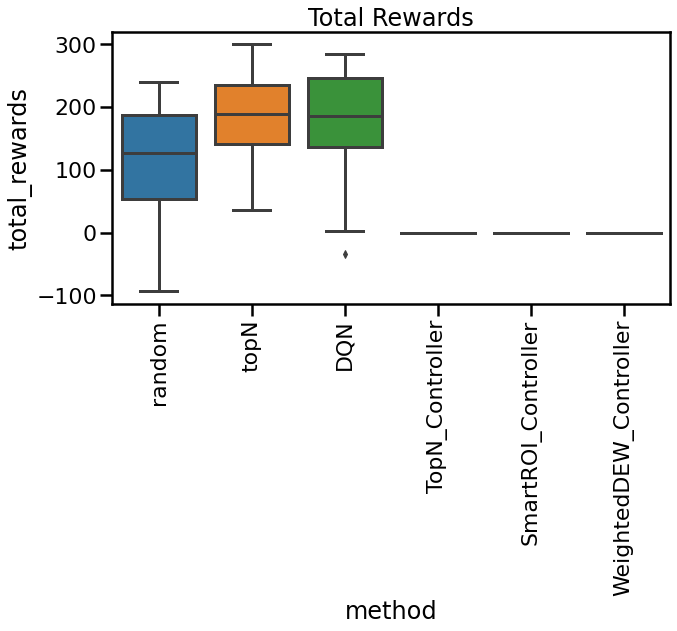

In [32]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='total_rewards')
plt.xticks(rotation=90)
plt.title('Total Rewards')

Text(0.5, 1.0, 'Invalid Action Count')

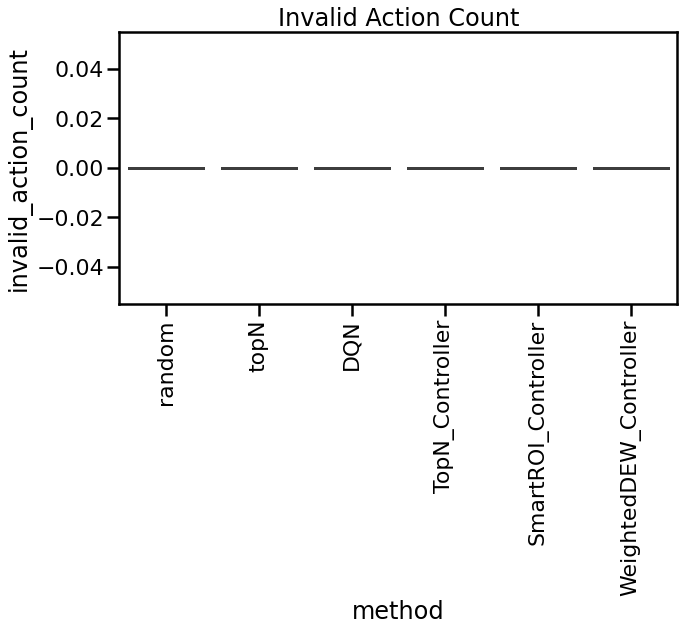

In [33]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='invalid_action_count')
plt.xticks(rotation=90)
plt.title('Invalid Action Count')

Text(0.5, 1.0, 'Coverage Proportion')

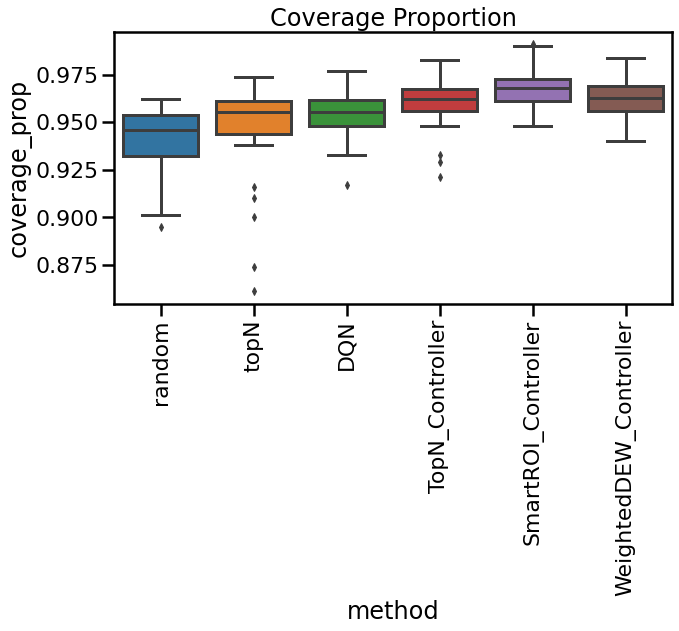

In [34]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='coverage_prop')
plt.xticks(rotation=90)
plt.title('Coverage Proportion')

Text(0.5, 1.0, 'Intensity Proportion')

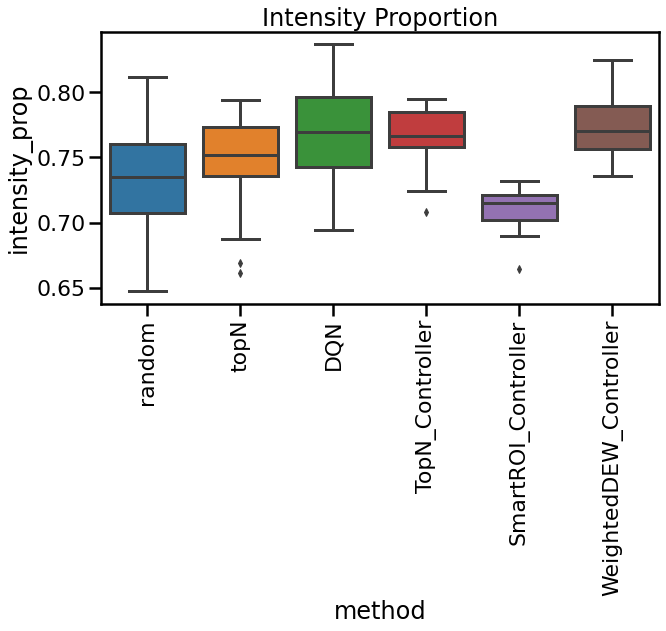

In [35]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='intensity_prop')
plt.xticks(rotation=90)
plt.title('Intensity Proportion')

Text(0.5, 1.0, 'MS1/MS2 Ratio')

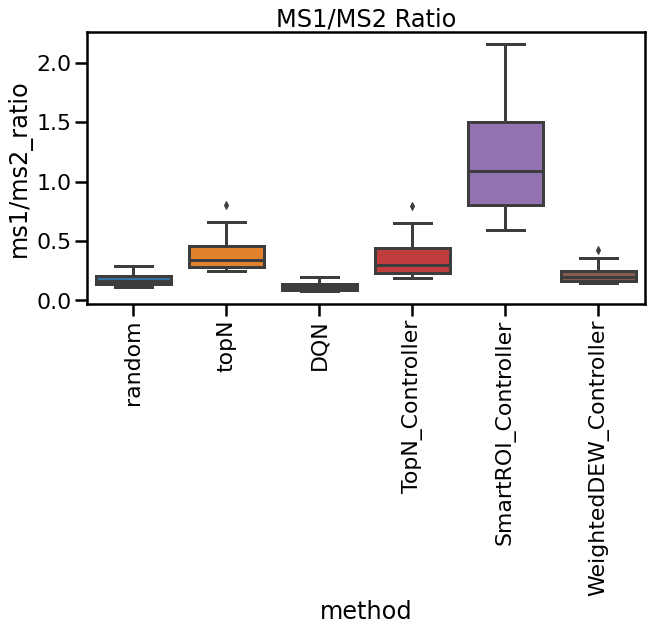

In [36]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='ms1/ms2_ratio')
plt.xticks(rotation=90)
plt.title('MS1/MS2 Ratio')

Text(0.5, 1.0, 'Efficiency')

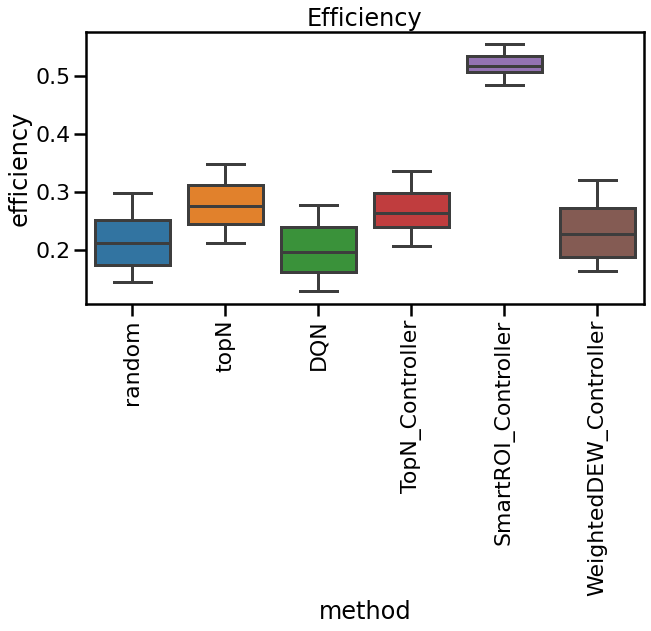

In [37]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='efficiency')
plt.xticks(rotation=90)
plt.title('Efficiency')

Text(0.5, 1.0, 'Precision')

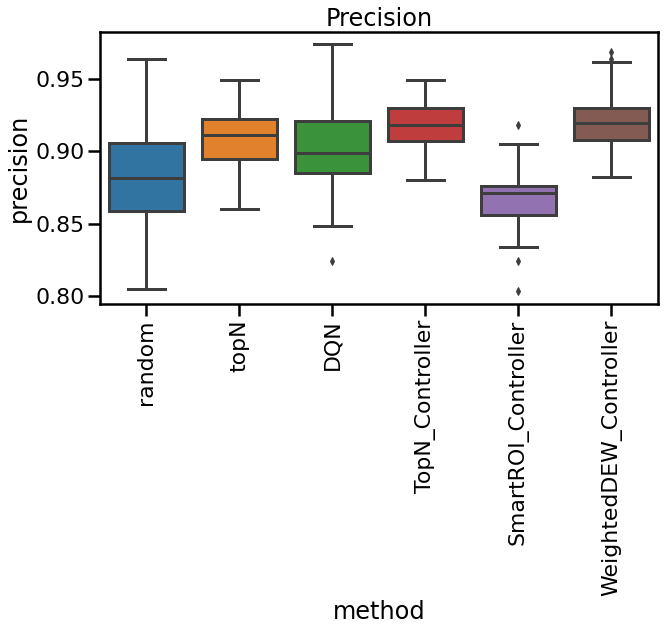

In [38]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='precision')
plt.xticks(rotation=90)
plt.title('Precision')

Text(0.5, 1.0, 'Recall')

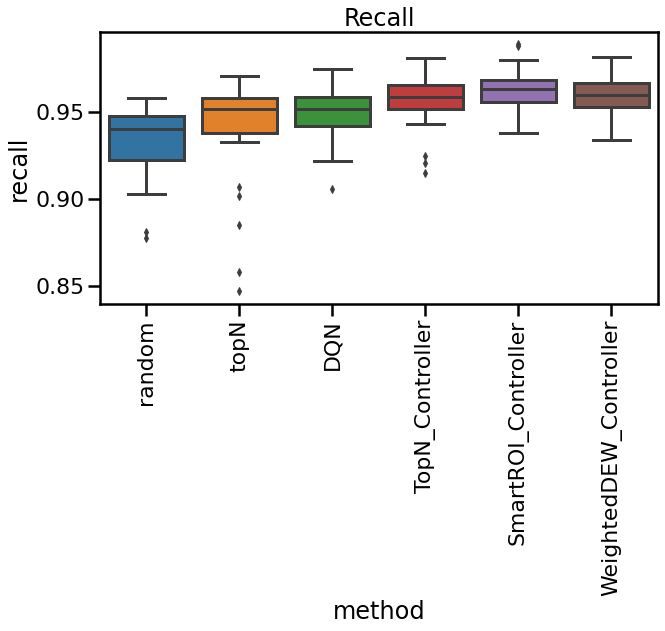

In [39]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='recall')
plt.xticks(rotation=90)
plt.title('Recall')

Text(0.5, 1.0, 'F1')

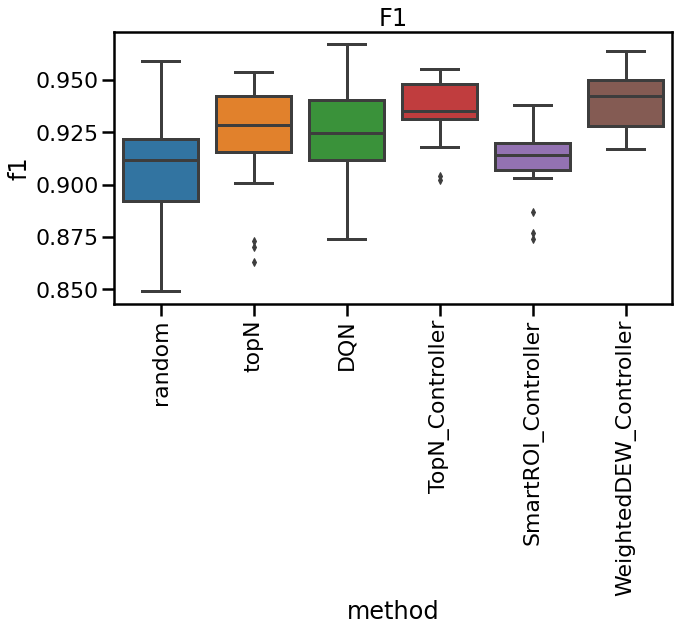

In [40]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='method', y='f1')
plt.xticks(rotation=90)
plt.title('F1')

In [41]:
df.to_pickle('evaluation_1.0E6_horizon_%d_alpha_%.2f_beta_%.2f.p' % (horizon, env_alpha, env_beta))